<a href="https://colab.research.google.com/github/Ryzzuh/the_plane_problem/blob/master/STAT278_Simulation_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Please run the code below to initialize this project

In [0]:
from IPython.display import clear_output

# install dependencies to vitualised instance
!pip install plotnine
!pip install scipy==1.2 --upgrade

# download images
!curl http://theflight.info/wp-content/uploads/2017/04/Seat_Map_Airbus_A320-200_Jetstar_Airlines.jpg --output A320_200.jpg
!curl http://theflight.info/wp-content/uploads/2017/04/Seat_Map_Airbus_A321-200_Jetstar_Airlines.jpg --output A321_200.jpg  
!curl https://airlinesfleet.com/wp-content/uploads/2019/03/Seat-Map-and-Seating-Chart-Bombardier-Dash-8-Q300-Jetstar.jpg --output Bombardier.jpg  
clear_output()

In [0]:
#@title
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu May  2 23:25:39 2019

@author: rhysall
"""
#relase notes
#v.09 added the following features
#addition of core classes, plane and passenger

#from os import system
from time import sleep
import random
import math
import pandas as pd
import plotnine
from plotnine import *
plotnine.options.figure_size = (12, 8)
import os



# Welcome to Group Kappa's Jetstar passenger boarding simulation 

![alt JS_logo](https://s3-eu-west-1.amazonaws.com/sendmybag/media/third-party/jetstar-logo.png)

You have chosen the... Bombardier_Dash_8


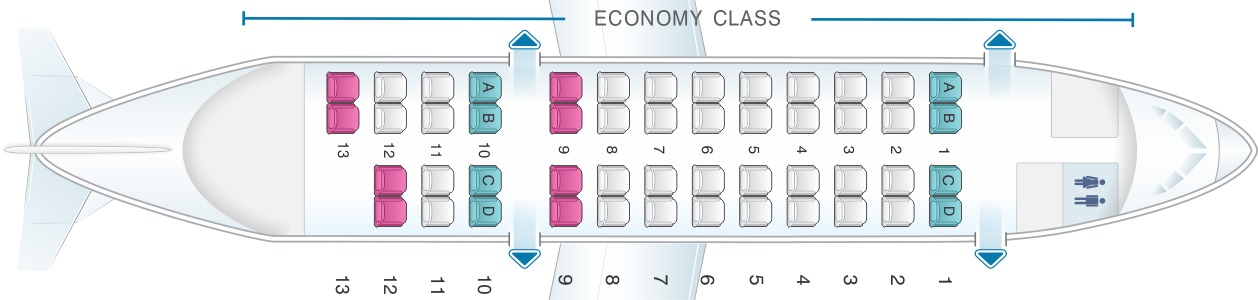

In [16]:
#@title  { run: "auto" }
#@markdown Please select your Aircraft
plane_type = "Bombardier_Dash_8" #@param ["A320_200", "A321_200", "Bombardier_Dash_8"] {allow-input: false}
#@markdown How many simulations? 5-20 recommended
n_runs = 15 #@param {type:"number"}
#@markdown Show simulation running? (not recommended)
display_output = False #@param {type:"boolean"}
#@markdown Wait time between output display (display_output must be checked)
sleep_time_s = 1.1 #@param {type:"slider", min:0.05, max:2, step:0.15}





from IPython.display import Image, display
print("You have chosen the... {}".format(plane_type))

aircraft = {"A320_200": "A320_200.jpg",
           "A321_200": "A321_200.jpg",
            "Bombardier_Dash_8": "Bombardier.jpg"
           }
display(Image(aircraft[plane_type],width=800,height=250))

In [0]:

class booking_system:
    
    def __init__(self):
        pass
    
    def all_seats(self, plane):
        seats=[[x,y] for x in range(plane.h)\
              for y in range(plane.w) if y != plane.corridor]
        return seats
    
    
    def random_seats(self, plane):
        seats = self.all_seats(plane)[::-1]
        random.shuffle(seats)
        return seats
    
    
    def back_to_front(self, plane):
        seats=[[x,y] for x in range(plane.h)[::-1]\
              for y in range(plane.w) if y != plane.corridor]
        print(len(seats)/2)
        temp_1 = seats[:round(len(seats)/2)]
        temp_2 = seats[round(len(seats)/2):]
        random.shuffle(temp_1)
        random.shuffle(temp_2)
        final_seats = temp_1+temp_2
        return(final_seats)
    
    
    def window_to_aisle_seats(self, plane):
        seats = []
        aisle_pairs = [[x, plane.w -x-1] for x in \
                range(math.floor(plane.w/2))]
        
        for pair in aisle_pairs:
            for x in pair:
                for y in range(plane.h)[::-1]:
                    seats.append([y, x])
                    
        temp_seats = []
        for x, group in enumerate(range(round(len(seats)/plane.h))):
            x = seats[x*plane.h:(x+1)*plane.h]
            random.shuffle(x)
            temp_seats += x
        return temp_seats
    
    
    def steffen_perfect(self, plane):
        seats = []
        aisle_pairs = [[x, plane.w -x-1] for x in \
                range(math.floor(plane.w/2))]
        for pair in aisle_pairs:
            for x in pair:
                for y in range(plane.h)[::-1]:
                    seats.append([y, x])
        temp_1 = seats[::2]
        temp_2 = seats[1::2]
        temp_seats = []
        for x in range(round(math.floor(plane.w/2))):
            temp_seats += temp_1[x*(plane.h):(x+1)*(plane.h)] \
            +temp_2[x*(plane.h):(x+1)*(plane.h)]
        return temp_seats


class plane():
    
    ''' planes come as static (for now) 2d array '''
    def __init__(self, width, height):
        self.h, self.w = height, width
        self.seats = [[0 for x in range(self.w)] for y in range(self.h)]
        self.seated_passengers = [[0 for x in range(self.w)] for y in range(self.h)]
        self.boarded_passengers = []
        self.corridor =  math.floor((len(self.seats[0]))/2)
        self.passengers = []


    ''' update positions passengers '''
    def update_position(self, passenger, curr_poss, new_pos):
        self.seats[new_pos[0]][new_pos[1]] = passenger
        self.seats[curr_poss[0]][curr_poss[1]] = 0
        
        
    ''' planes can display the seats (for human consumption) '''
    def display_seats(self):
        print(" -----------------------")
        for row in self.seats:
            x = map(lambda x:"#" if isinstance(x,passenger) else "-", row)
            print(list(x))
        print(" -----------------------")
        
        
    def any_blockage(self, pnger):
        p_seat = pnger.seat
        p_row = list(map(lambda x:1 if \
                     isinstance(x,passenger) else 0, self.seats[p_seat[0]]))
        
        if p_seat[1] < self.corridor: #if left of isle
            sect = p_row[pnger.seat[1]:self.corridor]
            if sum(sect)>0 and pnger.position[1] == self.corridor:
                return sect[::-1].index(1)+1
            else:
                return 0 # "no blockage left"
        elif p_seat[1] > self.corridor: #else right of aisle
            sect = p_row[self.corridor+1:pnger.seat[1]]
            if sum(sect)>0 and pnger.position[1] == self.corridor:
                return sect.index(1)+1
            else:
                return 0 # "no blockage left"


    def all_seated(self):
        bool_all_seated = list(map(lambda x: \
                              True if x.is_seated \
                              else False, self.boarded_passengers))
        if len(self.boarded_passengers) > 0:
            return sum(bool_all_seated) == len(self.boarded_passengers)
        
        
    def is_entry_empty(self):
        if isinstance(self.seats[0][self.corridor], passenger):
            return False
        else:
            return True
        
        
    def board_passenger(self, passenger):
        self.seats[0][self.corridor]= passenger
        passenger.position = [0,self.corridor]
        #system('clear')
        clear_output(wait=True)
        
    
    def seat_passengers(self):
        i = 0
        while not self.all_seated():
            if self.is_entry_empty() == True and len(self.passengers) > 0:
                self.boarded_passengers.append(self.passengers.pop(0))
                self.board_passenger(self.boarded_passengers[-1])
            for bp in self.boarded_passengers:
                if not bp.is_seated:
                    bp.find_seat()
                #print(bp.seat, bp.position)
            if display_output == True:
              self.display_seats()
              sleep(sleep_time_s)
              #system('clear')
              clear_output(wait=True)
            i+=1
            print(i)
            clear_output()
        return i



class passenger():
    
    
    def __init__(self, plane, seat):
        self.plane = plane
        self.seat = seat # row, aisle
        self.position = [0,0] # row, aisle
        self.is_seated = False
        '''can configure skewing this distribution !!! look to print graph'''
        self.luggage_time = \
        '''the below should be a function which is called on initalisation
        it should also increase the range as time passes - finding room for
        lugguage is increasingly harder as more passengers stow their own'''
        random.choices\
            (range(0, 6), weights=(0.2, 0.1, 0.15, 0.15, 0.25, 0.15))
        self.luggage_time = None
        self.wait_block = None
        
        '''add Markov property to increase range as time passes'''
    def adjust_luggage(self, time_passed):
        self.luggage_time = \
        random.choices(range(3, time_passed), \
                       weights=(0.2, 0.1, 0.15, 0.15, 0.25, 0.15))
        return 1
        
    
    def find_seat(self):
        '''NEXT, incorporate wait time if someone blocking seat'''
        if self.position == self.seat:
            if self.is_seated == False:
                self.is_seated = True
        elif self.position[0] == self.seat[0]:
            '''if n people in way, pass n turns'''
            self.move_horizontally()
        else:
            self.move_forward()
    
    def move_forward(self):
        pos = self.position
        if pos[0] < len(self.plane.seats)-1 \
        and isinstance(self.plane.seats[pos[0]+1][self.plane.corridor],passenger)==False:
            self.plane.update_position(self, pos, [pos[0]+1, pos[1]])
            pos[0] = pos[0] + 1


    def move_horizontally(self):
        pos = self.position
        blockage = self.plane.any_blockage(self)
        if self.is_seated == True:
            pass
        elif self.luggage_time == None:
            x = random.choices\
            (range(1, 7), weights=(0.2, 0.1, 0.15, 0.15, 0.25, 0.15))
            self.luggage_time = x[0] - 1
        elif self.luggage_time > 0:
            self.luggage_time -= 1
        elif self.luggage_time == 0:
            if blockage == 0 and self.is_seated == False:
                if pos < self.seat:
                    self.move_right()
                elif pos > self.seat:
                    self.move_left()
            elif blockage > 0 and self.wait_block == None and self.is_seated == False:
                ''' blockage algebra '''
                self.wait_block = blockage*2 - 1
            elif blockage > 0 and self.wait_block > 0 and self.is_seated == False:
                self.wait_block -=1
            elif blockage > 0 and self.wait_block == 0 and self.is_seated == False:
                self.plane.update_position(self, pos, self.seat)
                pos[1] = self.seat[1]
            

    def move_right(self):
        pos = self.position
        self.plane.update_position(self, pos, [pos[0], pos[1]+1])
        pos[1] = pos[1] + 1
        
            
    def move_left(self):
        pos = self.position
        self.plane.update_position(self, pos, [pos[0], pos[1]-1])
        pos[1] = pos[1] - 1


class fleet():
    
    def A320_200(self):
        return plane(7, 30)
    
    
    def A321_200(self):
        return plane(7, 37)
    
    
    def Bombardier_Dash_8(self):
        return plane(5, 12)



# Ready to run the simulation!!

In [15]:

plane_selection = {"A320_200": fleet().A320_200(),
           "A321_200": fleet().A321_200(),
            "Bombardier_Dash_8": fleet().Bombardier_Dash_8()
           }


      
bs = booking_system
plane_name = plane_type

if plane_type == "A320_200":
  w=7
  h=30
elif plane_type == "A321_200":
  w=7
  h=37
elif plane_type == "Bombardier_Dash_8":
  w=7
  h=12
'''
planes = [plane(w,h)
          , plane(w,h)
          , plane(w,h)
          , plane(w,h)]
'''
planes = [plane(w,h)
          , plane(w,h)
          , plane(w,h)
          , plane(w,h)]
seating_patterns = [bs().random_seats
    ,bs().back_to_front
    ,bs().window_to_aisle_seats
    ,bs().steffen_perfect]


for i, sp in enumerate(seating_patterns):
    #print("sp",sp)
    #print("i",i)
    seating_patterns[i] = sp(planes[i])
sleep(1)

final_results = []

for i, sp in enumerate(seating_patterns):
    #print(sp)
    results = []

    for r in range (n_runs):
        #system('clear')
        pl = planes[i]
        booked_seats = sp
        #print("seats in pattern",sp)

        for seat in booked_seats:
            pl.passengers.append(passenger(pl, seat))
            
        time = pl.seat_passengers()
        results.append(time)
        #print("time:",time)
        #print(results)
        #sleep(5)
        pl.__init__(w,h)
        del(pl)
        del(booked_seats)
    final_results.append(results)
    
#print(final_results)

patterns = ["random","rear to front", "window to aisle", "steffen perfect"]
data = {"pattern":[],"time":[]}
for i, results in enumerate(final_results):
    for time in results:
        data["pattern"].append(patterns[i])
        data["time"].append(time)
#print(data)
        

d = {"pattern":data["pattern"], "time": data["time"]}
df = pd.DataFrame(data=d)
print(df)
df.head

#my_plot = ggplot(data=df, mapping=aes(x='time', fill='pattern', width = 50 ))+ stat_density(adjust = 1/4, alpha=0.5)+coord_cartesian(xlim=[0,1000])
my_plot = ggplot(data=df, mapping=aes(x='time', fill='pattern', width = 50 ))+ stat_density(adjust = 1/4, alpha=0.5)
print(my_plot)

df_random = df[df.pattern == "random"]
df_window_to_aisle = df[df.pattern == "window to aisle"]
df_rear_to_front = df[df.pattern == "rear to front"]
steffen_perfect = df[df.pattern == "steffen perfect"]

print(df_random['time'].describe())
print(df_window_to_aisle['time'].describe())
print(df_rear_to_front['time'].describe())
print(steffen_perfect['time'].describe())


print("done")


test
 -----------------------
['-', '#', '#', '-', '-', '-', '-']
['-', '#', '#', '#', '#', '#', '-']
['#', '#', '-', '#', '#', '-', '-']
['-', '#', '#', '-', '#', '#', '-']
['-', '-', '#', '-', '-', '#', '-']
['-', '#', '-', '-', '-', '#', '-']
['-', '#', '#', '-', '-', '#', '#']
['#', '#', '-', '#', '-', '-', '#']
['-', '-', '#', '#', '#', '-', '#']
['#', '-', '-', '#', '#', '-', '-']
['-', '-', '-', '-', '-', '#', '-']
['#', '#', '-', '-', '-', '#', '#']
 -----------------------


KeyboardInterrupt: ignored